Starting point for MNIST digit classification according to Jalalvand

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from pyrcn.echo_state_network import ESNClassifier
from pyrcn.linear_model import IncrementalRegression
from pyrcn.base import InputToNode, NodeToNode

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline

Load the dataset

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

Provide standard split in training and test. Further split training set for validation. Normalize to a range between [0, 1].

Reshape to obtain 28x28 images

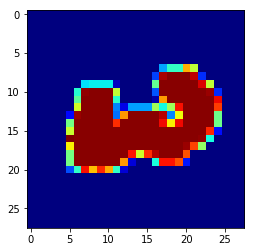

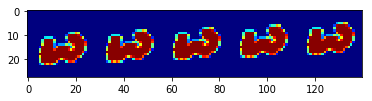

In [3]:
X_train, X_test = X[:60000] / 255., X[60000:] / 255.
y = y.astype(int)
y_train, y_test = y[:60000], y[60000:]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

X_train = [X_train[k].reshape(28, 28).T for k in range(len(X_train))]
X_val = [X_val[k].reshape(28, 28).T for k in range(len(X_val))]
X_test = [X_test[k].reshape(28, 28).T for k in range(len(X_test))]
plt.figure()
plt.imshow(X_train[1])
X_tmp = np.pad(X_train[1], ((2, 2), (0, 0)), 'edge')
X_tmp = np.concatenate((X_tmp[:-4, :], X_tmp[1:-3, :], X_tmp[2:-2, :], X_tmp[3:-1, :], X_tmp[4:, :]), axis=1)
plt.figure()
plt.imshow(X_tmp)

Provide a basic ESN with Aza's parameters

In [4]:
base_input_to_nodes = InputToNode(hidden_layer_size=500, activation='identity', k_in=10, input_scaling=0.4, bias_scaling=0.0)
base_nodes_to_nodes = NodeToNode(hidden_layer_size=500, spectral_radius=0.4, leakage=0.5, bias_scaling=0.3, k_rec=10)

esn = ESNClassifier(input_to_nodes=[('default', base_input_to_nodes)],
                    nodes_to_nodes=[('default', base_nodes_to_nodes)],
                    regressor=IncrementalRegression(alpha=1e-3), random_state=10)

Validate that the target preparation works correct

In [5]:
X = np.pad(X_train[1], ((2, 2), (0, 0)), 'edge')
X = np.concatenate((X[:-4, :], X[1:-3, :], X[2:-2, :], X[3:-1, :], X[4:, :]), axis=1)
X.shape


(28, 140)

In [6]:
y = np.repeat(y_train[0], repeats=28, axis=0)
y[np.argwhere(X.sum(axis=1)==0)] = 10
y

array([10, 10, 10, 10, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, 10, 10, 10, 10, 10])

Train this ESN

In [7]:
with tqdm(total=len(X_train)) as pbar:
    for X, y in zip(X_train, y_train):
        X = np.pad(X, ((2, 2), (0, 0)), 'edge')
        X = np.concatenate((X[:-4, :], X[1:-3, :], X[2:-2, :], X[3:-1, :], X[4:, :]), axis=1)
        y = np.repeat(y, repeats=28, axis=0)
        y[np.argwhere(X.sum(axis=1)==0)] = 10
        esn.partial_fit(X=X, y=y, classes=np.arange(11))
        pbar.update(1)        


100%|████████████████████████████████████████████████████████████████████████████| 48000/48000 [32:03<00:00, 24.95it/s]


In [8]:
with tqdm(total=len(X_val)) as pbar:
    for X, y in zip(X_val, y_val):
        X = np.pad(X, ((2, 2), (0, 0)), 'edge')
        X = np.concatenate((X[:-4, :], X[1:-3, :], X[2:-2, :], X[3:-1, :], X[4:, :]), axis=1)
        y = np.repeat(y, repeats=28, axis=0)
        y[np.argwhere(X.sum(axis=1)==0)] = 10
        esn.partial_fit(X=X, y=y)
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [08:01<00:00, 26.32it/s]


Compute final measurements

In [9]:
Y_true_train = []
Y_pred_train = []
with tqdm(total=len(X_train)) as pbar:
    for X, y in zip(X_train, y_train):
        X = np.pad(X, ((2, 2), (0, 0)), 'edge')
        X = np.concatenate((X[:-4, :], X[1:-3, :], X[2:-2, :], X[3:-1, :], X[4:, :]), axis=1)
        y_pred = esn.predict_proba(X=X)[4:-4, :-1]
        Y_true_train.append(y)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        pbar.update(1)

with tqdm(total=len(X_val)) as pbar:
    for X, y in zip(X_val, y_val):
        X = np.pad(X, ((2, 2), (0, 0)), 'edge')
        X = np.concatenate((X[:-4, :], X[1:-3, :], X[2:-2, :], X[3:-1, :], X[4:, :]), axis=1)
        y_pred = esn.predict_proba(X=X)[4:-4, :-1]
        Y_true_train.append(y)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        pbar.update(1)

Y_true_test = []
Y_pred_test = []
with tqdm(total=len(X_test)) as pbar:
    for X, y in zip(X_test, y_test):
        X = np.pad(X, ((2, 2), (0, 0)), 'edge')
        X = np.concatenate((X[:-4, :], X[1:-3, :], X[2:-2, :], X[3:-1, :], X[4:, :]), axis=1)
        y_pred = esn.predict_proba(X=X)[4:-4, :-1]
        Y_true_test.append(y)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.46it/s]


Confusion matrices

Classification training report for estimator ESNClassifier(input_to_nodes=[('default',
                               InputToNode(activation='identity',
                                           bias_scaling=0.0, input_scaling=0.4,
                                           k_in=10,
                                           random_state=RandomState(MT19937) at 0x1FAFEF69048,
                                           sparsity=0.07142857142857142))],
              nodes_to_nodes=[('default',
                               NodeToNode(bias_scaling=0.3, k_rec=10,
                                          leakage=0.5,
                                          random_state=RandomState(MT19937) at 0x1FAFEF69048,
                                          sparsity=0.02,
                                          spectral_radius=0.4))],
              random_state=RandomState(MT19937) at 0x1FA940507B8,
              regressor=IncrementalRegression(alpha=0.001)):
              precision    recall

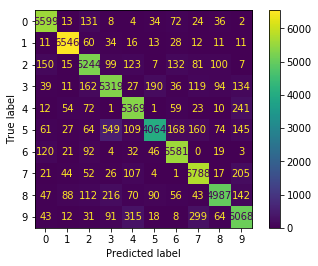

Classification test report for estimator ESNClassifier(input_to_nodes=[('default',
                               InputToNode(activation='identity',
                                           bias_scaling=0.0, input_scaling=0.4,
                                           k_in=10,
                                           random_state=RandomState(MT19937) at 0x1FAFEF69048,
                                           sparsity=0.07142857142857142))],
              nodes_to_nodes=[('default',
                               NodeToNode(bias_scaling=0.3, k_rec=10,
                                          leakage=0.5,
                                          random_state=RandomState(MT19937) at 0x1FAFEF69048,
                                          sparsity=0.02,
                                          spectral_radius=0.4))],
              random_state=RandomState(MT19937) at 0x1FA940507B8,
              regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1

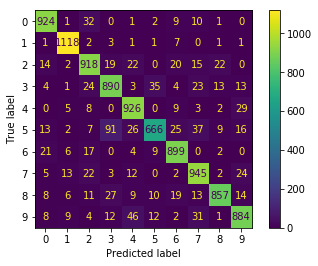

In [10]:
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n"
  % (esn, classification_report(Y_true_train, Y_pred_train, digits=4)))
plt.show()

cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n"
  % (esn, classification_report(Y_true_test, Y_pred_test, digits=4)))
plt.show()

Optimization of hyper-parameters

In [11]:
base_input_to_nodes = InputToNode(hidden_layer_size=500, activation='identity', k_in=10, input_scaling=0.4, bias_scaling=0.0)
base_nodes_to_nodes = NodeToNode(hidden_layer_size=500, activation='tanh', spectral_radius=0.0, leakage=1.0, bias_scaling=0.0, k_rec=10)
regressor=IncrementalRegression(alpha=1e-3)

grid = {'input_scaling': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5], 
        'spectral_radius': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
       }
base_esn = ESNClassifier(input_to_nodes=[('default', base_input_to_nodes)],
                         nodes_to_nodes=[('default', base_nodes_to_nodes)],
                         regressor=IncrementalRegression(alpha=1e-3), random_state=10)

In [12]:
def opt_function(base_input_to_node, base_node_to_node, params, X_train, y_train, X_test, y_test):
    input_to_nodes = clone(base_input_to_nodes)
    nodes_to_nodes = clone(base_nodes_to_nodes)
    input_to_nodes.set_params(**{'input_scaling': params['input_scaling']})
    nodes_to_nodes.set_params(**{'spectral_radius': params['spectral_radius']})
    esn = ESNClassifier(input_to_nodes=[('default', input_to_nodes)],
                        nodes_to_nodes=[('default', nodes_to_nodes)],
                        regressor=IncrementalRegression(alpha=5e-3), random_state=10)
    for X, y in zip(X_train, y_train):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        reg.partial_fit(X=X, y=y, update_output_weights=False)
    reg.finalize()
    err_train = []
    for X, y in zip(X_train, y_train):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        y_pred = reg.predict(X=X, keep_reservoir_state=False)
        err_train.append(mean_squared_error(y, y_pred))
    err_test = []
    for X, y in zip(X_test, y_test):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        y_pred = reg.predict(X=X, keep_reservoir_state=False)
        err_test.append(mean_squared_error(y, y_pred))
    return [np.mean(err_train), np.mean(err_test)]